In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pylab as plt
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [3]:
def import_files(path):
    struc = pd.DataFrame(columns =["radiation_level", "path","code_file","group"])
    read = os.walk(path)
    for root, dirs, files in read:
        for name in files:
            if name.endswith(".csv"):
                #print(name)
                radiation = name.split("gy")
                [_,group,_] = name.split("_") 
                filepath = path+ '/' + name
                code_file = name[:-4] #removing suffix
                
                struc = struc.append({"radiation_level" : int(radiation[0]), "path" : filepath, "code_file" : code_file, "group" : group}, ignore_index=True)
                
    return struc

In [4]:
def str_to_numpy(input_str):
    """
    str_to_numpy is used to parse the columns "input" and "output" of the dataset csv files.
    It converts a string representing an array of cells to a numpy array containing strings
    which are the names of these cells.
    """
    process_str = input_str.replace("[", "")
    process_str = process_str.replace("'", "")
    process_str = process_str.replace(" ", "")
    process_str = process_str.replace("]", "")
    if(process_str != ""):
        process_str = process_str.split(",")
        output_array = np.asarray(process_str, dtype=str)
    else:
        output_array = np.asarray([], dtype=str)
    return output_array

In [5]:
def root_cell_test(row, root): #Tests if the row corresponds to the root cell
    for c in row.input:
        if str(c).startswith(root):
            return True

    return False

def obtain_roots(experience):
    roots = experience.loc[experience.event == 'begin'].output 
    root_cells = []
    for cell in roots:
        root_cells.append(str(cell[0]))
    return(root_cells)

def cells_to_trees(experience): #experience is a DataFrame
    #Select root cells in experience
    root_cells = obtain_roots(experience)

    #Creation of a tree corresponding to the experience
    trees = pd.DataFrame(columns = ["root_cell", "time","event","input","output"])
    for root in root_cells:
        #exp_bis = experience.loc[experience.event != "begin"]
        f = lambda row:root_cell_test(row, root)
        root_cell = experience[experience.apply(f, axis=1)]
        root_cell.insert(loc=0, column='root_cell', value=root, allow_duplicates=True)
        #trees = trees.append(root_cell)
        root_cell=root_cell.sort_values(by='time')
        trees = pd.concat([trees, root_cell], ignore_index=True, sort=False)
    return trees

In [6]:
path = '../input/glioblastoma-radiosensitivity-dataset/glioblastoma_data/extracted_data/cell_behaviors/videos_transcriptions_csv'
file = path + "/0gy_n1_201104.nd2u2510Gy1A.csv"
experience = pd.read_csv(file, converters = {"input" : str_to_numpy, "output" : str_to_numpy})
trees = cells_to_trees(experience)
trees
root_cells = obtain_roots(experience)

features = pd.DataFrame({'root_cells' : root_cells})
features


,root_cells
0,C1
1,C2
2,C3
3,C4
4,C5
5,C6
6,C7
7,C8
8,C9


Features à rajouter : 
    - groupe d'expérience
    - taux de radiation

Regrouper toutes les feautres pour une même expérience

In [33]:
def cell_lineage_exp(experience):

    trees = cells_to_trees(experience)

    root_cells = obtain_roots(experience)
    features = pd.DataFrame({'root_cells' : root_cells})
    
    features['nb_divisions'] = features['root_cells'].map(trees.loc[trees.event=='div'].groupby(['root_cell']).root_cell.count())
    features['nb_fusions'] = features['root_cells'].map(trees.loc[trees.event=='fusion'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    features['nb_deaths'] = features['root_cells'].map(trees.loc[trees.event=='death'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    
    features['cells_alive_at_end'] = features['root_cells'].map(trees.loc[trees.event=='end'].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    
    features['nb_divisions_d1'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d2'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d3'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_divisions_d4'] = features['root_cells'].map(trees.loc[(trees.event=='div') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())

    features= features.fillna(0)


    features['prop_cells_alive'] = features.cells_alive_at_end / (features.nb_divisions + 1)
    
    features['nb_deaths_d1'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d2'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d3'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_deaths_d4'] = features['root_cells'].map(trees.loc[(trees.event=='death') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)


    features['nb_fusions_d1'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d2'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 2*144) & (trees.time > 144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d3'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 3*144) & (trees.time > 2*144)].groupby(['root_cell']).root_cell.count())
    features['nb_fusions_d4'] = features['root_cells'].map(trees.loc[(trees.event=='fusion') & (trees.time <= 4*144) & (trees.time > 3*144)].groupby(['root_cell']).root_cell.count())
    features= features.fillna(0)

    features['cells_alive_d1'] = features.nb_divisions_d1 + 1 - features.nb_deaths_d1 - features.nb_fusions_d1
    features['cells_alive_d2'] = features.cells_alive_d1 +features.nb_divisions_d2 - features.nb_deaths_d2 - features.nb_fusions_d2
    features['cells_alive_d3'] = features.cells_alive_d2 +features.nb_divisions_d3 - features.nb_deaths_d3 - features.nb_fusions_d3
    features['cells_alive_d4'] = features.cells_alive_d3 +features.nb_divisions_d4  - features.nb_deaths_d4 - features.nb_fusions_d4
    features= features.fillna(0)


    return features

    

In [60]:
feat = cell_lineage_exp(experience)

feat

feat['radiation_lvl']='oui'
feat

,root_cells,nb_divisions,nb_fusions,nb_deaths,cells_alive_at_end,nb_divisions_d1,nb_divisions_d2,nb_divisions_d3,nb_divisions_d4,prop_cells_alive,...,nb_deaths_d4,nb_fusions_d1,nb_fusions_d2,nb_fusions_d3,nb_fusions_d4,cells_alive_d1,cells_alive_d2,cells_alive_d3,cells_alive_d4,radiation_lvl
0,C1,7,0.0,0.0,8.0,1,2.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,oui
1,C2,2,1.0,0.0,3.0,1,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,oui
2,C3,7,0.0,0.0,8.0,1,2.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,oui
3,C4,4,0.0,0.0,5.0,1,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,5.0,5.0,oui
4,C5,14,0.0,0.0,15.0,1,3.0,10.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,5.0,15.0,15.0,oui
5,C6,7,0.0,0.0,8.0,1,2.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,oui
6,C7,7,0.0,0.0,8.0,1,2.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,oui
7,C8,1,1.0,1.0,0.0,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,oui
8,C9,4,0.0,0.0,4.0,1,1.0,2.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,5.0,5.0,oui


In [46]:
files = import_files(path)

files

,radiation_level,path,code_file,group
0,0,../input/glioblastoma-radiosensitivity-dataset...,0gy_n1_201104.nd2u2510Gy1A,n1
1,0,../input/glioblastoma-radiosensitivity-dataset...,0gy_n1_201104.nd2u2510GyA3A,n1
2,0,../input/glioblastoma-radiosensitivity-dataset...,0gy_n1_2020 11 04 .0Gy B2A,n1
3,0,../input/glioblastoma-radiosensitivity-dataset...,0gy_n1_2020 11 04 0Gy 1A,n1
4,0,../input/glioblastoma-radiosensitivity-dataset...,0gy_n1_2020 11 04 0Gy A2B,n1
...,...,...,...,...
176,8,../input/glioblastoma-radiosensitivity-dataset...,8gy_n3_2021 11 11 8Gy B4C,n3
177,8,../input/glioblastoma-radiosensitivity-dataset...,8gy_n3_2021 11 11 8Gy C3A,n3
178,8,../input/glioblastoma-radiosensitivity-dataset...,8gy_n3_2021 11 11 8Gy C3C,n3
179,8,../input/glioblastoma-radiosensitivity-dataset...,8gy_n3_2021 11 11 8Gy C4A,n3


In [74]:
def cell_lineage(path):

    files = import_files(path)

    cl = pd.DataFrame()

    for file in files.itertuples():

        file_path = path + "/" + file.code_file + ".csv"

        exp = pd.read_csv(file_path, converters = {"input" : str_to_numpy, "output" : str_to_numpy})


        feature = cell_lineage_exp(exp)

        feature['radiation_lvl'] = file.radiation_level
        feature['exp_group'] = file.group
        

        cl = cl.append(feature, ignore_index=True)


    return cl
    

In [75]:
cl = cell_lineage(path)

cl

,root_cells,nb_divisions,nb_fusions,nb_deaths,cells_alive_at_end,nb_divisions_d1,nb_divisions_d2,nb_divisions_d3,nb_divisions_d4,prop_cells_alive,...,nb_fusions_d1,nb_fusions_d2,nb_fusions_d3,nb_fusions_d4,cells_alive_d1,cells_alive_d2,cells_alive_d3,cells_alive_d4,radiation_lvl,exp_group
0,C1,7.0,0.0,0.0,8.0,1.0,2.0,4.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,0,n1
1,C2,2.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,1.000000,...,0.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,0,n1
2,C3,7.0,0.0,0.0,8.0,1.0,2.0,4.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.0,4.0,8.0,8.0,0,n1
3,C4,4.0,0.0,0.0,5.0,1.0,1.0,2.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.0,3.0,5.0,5.0,0,n1
4,C5,14.0,0.0,0.0,15.0,1.0,3.0,10.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,2.0,5.0,15.0,15.0,0,n1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2306,C7,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,8,n3
2307,C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8,n3
2308,C9,3.0,0.0,3.0,2.0,0.0,1.0,1.0,1.0,0.500000,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,8,n3
2309,C10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,8,n3


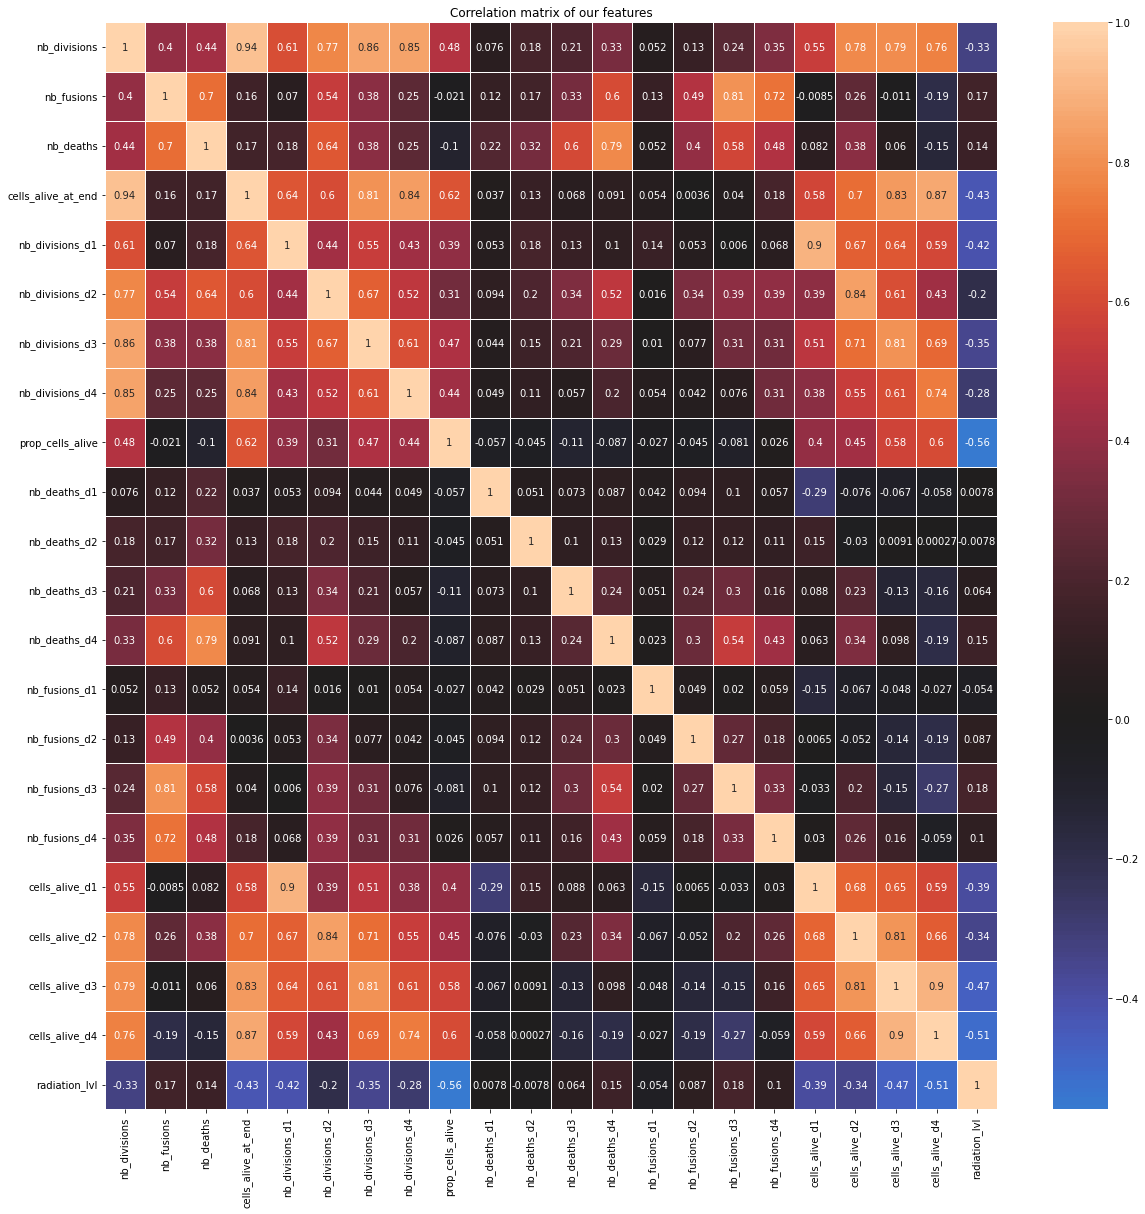

In [81]:
corr_matrix = cl.corr()

plt.figure(figsize=(20,20))
heat_map = sns.heatmap( corr_matrix, linewidth = 1 , annot = True, center=0)

plt.title( "Correlation matrix of our features" )
plt.show()